In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

In [31]:
warnings.filterwarnings("ignore", category=UserWarning)

In [32]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM

In [47]:
data_df = pd.read_excel("Data.xlsx", parse_dates=True, index_col='DATES')
data_df.dropna(inplace=True) # drop rows with nan

In [48]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_df)
print(scaled_data)

[[ 0.63171338  0.01806569 -1.15320773 ... -1.91047551 -1.3031791
   0.28507337]
 [ 0.43266785 -0.14291802 -1.18414515 ... -1.88787111 -1.30156746
   0.32570469]
 [ 0.52589171  0.11145018 -1.05420799 ... -1.86295003 -1.31908266
   0.53314088]
 ...
 [ 0.40621244 -0.18712652  0.02705477 ...  1.17350758  1.91562006
  -0.40274024]
 [-0.80947698 -0.03081203  0.10285145 ...  1.22586883  1.96222085
  -0.41408589]
 [-0.32572078  0.44689285  0.32250712 ...  1.14395316  1.94475125
  -0.45064803]]


In [54]:
n_regimes = 5
gmm = GaussianMixture(n_components=n_regimes,
                      covariance_type='full',
                      random_state=42,
                      n_init=10)
gmm.fit(scaled_data)
gmm_regimes = gmm.predict(scaled_data)
data_df['GMM_Regime'] = gmm_regimes
print(f"GMM model fitted. Found {len(np.unique(gmm_regimes))} regimes.")

GMM model fitted. Found 5 regimes.


In [55]:
hmm = GaussianHMM(n_components=n_regimes,
                    covariance_type='diag', # Often 'diag' or 'full' are used
                    n_iter=1000,          # Max iterations for EM algorithm
                    random_state=42,
                    tol=1e-3)             # Convergence tolerance

hmm.fit(scaled_data)
hmm_regimes = hmm.predict(scaled_data)
data_df['HMM_Regime'] = hmm_regimes
print(f"HMM model fitted. Found {len(np.unique(hmm_regimes))} regimes.")

HMM model fitted. Found 5 regimes.


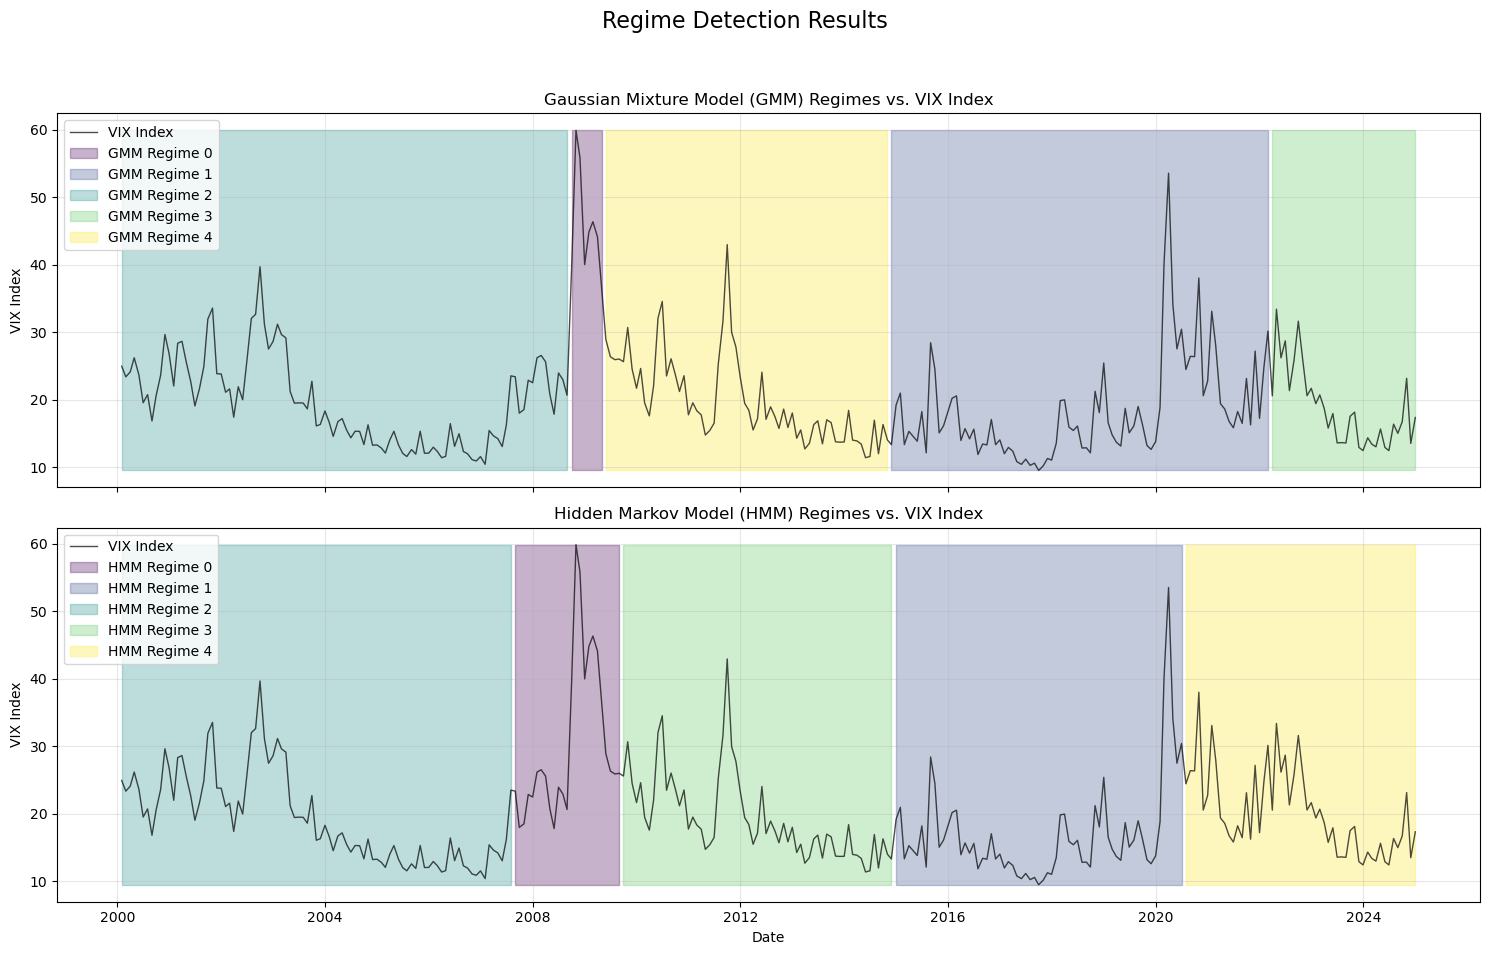

Analyzing regime characteristics...

--- GMM Regime Characteristics ---
            VIX Index  .TEDSP G Index  C 1 COMB Comdty  NG1 COMB Comdty  \
GMM_Regime                                                                
0           45.868750        1.640266       397.031250         5.264625   
1           18.336023        0.299378       405.721591         2.882239   
2           19.724615        0.445107       274.062500         6.198423   
3           18.647941        0.314164       551.125000         3.834441   
4           19.920455        0.261602       542.314394         3.922636   

            SI1 COMB Comdty  GT02 @BGN Govt  GT10 @BGN Govt  JPMVXYGL Index  \
GMM_Regime                                                                    
0                 11.803125        1.111981        3.069776       19.285000   
1                 18.269705        1.129833        1.929652        8.525568   
2                  8.061260        3.568166        4.592694        9.682308   
3      

In [56]:
# Data Visualisation
plot_col = 'VIX Index'

colors = plt.cm.viridis(np.linspace(0, 1, n_regimes))
gmm_colors = [colors[i] for i in gmm_regimes]
hmm_colors = [colors[i] for i in hmm_regimes]

fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
fig.suptitle('Regime Detection Results', fontsize=16)

axes[0].set_title(f'Gaussian Mixture Model (GMM) Regimes vs. {plot_col}')
axes[0].plot(data_df.index, data_df[plot_col], label=plot_col, color='black', alpha=0.7, linewidth=1)
axes[0].set_ylabel(plot_col)

# Color
for i in range(n_regimes):
    regime_mask = (data_df['GMM_Regime'] == i)
    label = f'GMM Regime {i}' if regime_mask.any() else None
    axes[0].fill_between(data_df.index, data_df[plot_col].min(), data_df[plot_col].max(),
                         where=regime_mask, color=colors[i], alpha=0.3, label=label)
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

axes[1].set_title(f'Hidden Markov Model (HMM) Regimes vs. {plot_col}')
axes[1].plot(data_df.index, data_df[plot_col], label=plot_col, color='black', alpha=0.7, linewidth=1)
axes[1].set_ylabel(plot_col)
axes[1].set_xlabel('Date')

# Color
if 'HMM_Regime' in data_df.columns:
    for i in range(n_regimes):
        regime_mask = (data_df['HMM_Regime'] == i)
        label = f'HMM Regime {i}' if regime_mask.any() else None
        axes[1].fill_between(data_df.index, data_df[plot_col].min(), data_df[plot_col].max(),
                            where=regime_mask, color=colors[i], alpha=0.3, label=label)
    axes[1].legend(loc='upper left')
else:
    axes[1].text(0.5, 0.5, 'HMM Skipped (Insufficient Data)', horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes)

axes[1].grid(True, alpha=0.3)


plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

print("Analyzing regime characteristics...")

print("\n--- GMM Regime Characteristics ---")
print(data_df.groupby('GMM_Regime')[data_df.columns].mean()) # Display mean values per regime

if 'HMM_Regime' in data_df.columns:
    print("\n--- HMM Regime Characteristics ---")
    print(data_df.groupby('HMM_Regime')[data_df.columns].mean()) # Display mean values per regime

print("\nAnalysis complete.")

In [57]:
# AIC calculation
n_regimes_range = range(2, 6)
gmm_aics = []
for n_components in n_regimes_range:
   gmm = GaussianMixture(n_components=n_components,
                           covariance_type='full',
                           random_state=42,
                           n_init=10)
   gmm.fit(scaled_data)
   gmm_aics.append(gmm.aic(scaled_data))
   
if len(gmm_aics) > 0 and np.min(gmm_aics) != np.inf:
   best_n_gmm = n_regimes_range[np.argmin(gmm_aics)]
   print(f"Best number of GMM regimes (lowest AIC): {best_n_gmm}")
else:
   print("Could not determine best GMM components via AIC. Defaulting to 3.")
   best_n_gmm = 3 

Best number of GMM regimes (lowest AIC): 5


In [58]:
hmm_aics = []
for n_components in n_regimes_range: 
    hmm = GaussianHMM(n_components=n_components,
                      covariance_type='diag',
                      n_iter=1000,
                      random_state=42,
                      tol=1e-3)
    hmm.fit(scaled_data)
    if hmm.monitor_.converged:
        current_aic = hmm.aic(scaled_data)
        hmm_aics.append(current_aic)
    else:
        hmm_aics.append(np.inf)

if len(hmm_aics) > 0 and np.min(hmm_aics) != np.inf :
    best_n_hmm = n_regimes_range[np.argmin(hmm_aics)]
    print(f"Best number of HMM regimes (lowest AIC): {best_n_hmm}")
else:
    print("Could not determine best HMM components via AIC. Defaulting to 3.")
    best_n_hmm = 3 

Model is not converging.  Current: -2883.002417702968 is not greater than -2882.9998999983304. Delta is -0.002517704637739371


Best number of HMM regimes (lowest AIC): 5
